In [ ]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer


## Part 1 - Implementing One layer Neural Network

This implementation of one hidden layer neural network is similar to the scikit-learn design of ML algorithms

In order to use our one hidden layer neural network for classification, user's must:


1.   Call the constructor **OneLayerNeuralNet** with the desired hyperparameters
2.   Call the method **fit** with the training features & target labels in pandas DataFrames
3.   Call the method **predict** with the testing dataframe

Below we can find the full implementation

### Algorithm Description

**Feedforward Step**

Each of the features in the input correspond to 1 neuron in the input layer. 

The number of neurons in the hidden layer are user defined. The activation of the hidden layer neuron is governed by a sigmoid or tanh or relu function which takes as input the weighted sum of the input layer activations

The output layer consists of 1 neuron which emits a 0 or 1 signal which is the predicted output for the input example. This activation is calculated as sigmoid of the weighted sum of hidden layer activations. This is simliar to  multiple logistic regression.


**Backpropogation**


We have referred to Andrew Ng's Deep Learning course (http://www.coursera.org/specializations/deep-learning) to build our backprop algorithm

The explanation of backprop is also available in 
https://www.ics.uci.edu/~pjsadows/notes.pdf

In the above reference, Peter Sadowski says it is standard to use a cross-entropy function in neural networks for two class classification problem

Our assigment also classifies the dataset into two classes. 
* For small dataset - 0/1 
* For large dataset - Automobile / Truck - 0/1

Hence our loss function is defined as
![Cross Entropy loss](https://wikimedia.org/api/rest_v1/media/math/render/svg/80f87a71d3a616a0939f5360cec24d702d2593a2)

For this cross entropy loss function, Andrew Ng's deep learning course 

has given us the Partial derivative with respect to all weights and biases in the vectorized format as 

![Andrew's equations ](https://miro.medium.com/max/714/1*ohfvtAN6AOV8mhBwr4PApQ.png)

which is what is implemented here.

Finally after the computing the gradients the parameters are updated using the equations given in http://ufldl.stanford.edu/tutorial/supervised/MultiLayerNeuralNetworks/

W = W - learning_rate * gradientW

B = B - learning_rate * gradientB

where gradients for W2, B2, W1, B1 is governed by the vectorised equations from above.






In [ ]:
#Author : Chandrakanth Cheturvedi 
class OneLayerNeuralNet():

  # Dict containing number of neurons in hidden layer,input & output layers 
  #                 number of iterations , activation function 
  __hyper_params = {}

  # Dict of Weights & biases for hidden layer & output 
  __network_params = {}

  # Dict of Activations and summations producing those activations
  __network_state = {}

  # train data
  __X_train = None
  __Y_train = None

  #Author : Chandrakanth Cheturvedi
  def __init__(self,hyper_params):
    self.__hyper_params = hyper_params
    
  #Author : Chandrakanth Cheturvedi
  def init_network_params(self):

    x = self.__hyper_params['input_neurons']
    h = self.__hyper_params['hidden_neurons']
    y = self.__hyper_params['output_neurons']
    
    # One row for each hidden layer neuron
    # one column for each input layer neuron
    W1 = np.random.randn(h, x) * 1e-02
    B1 = np.zeros(shape=(h, 1))

    W2 = np.random.randn(y, h) * 1e-02
    B2 = np.zeros(shape=(y, 1))

    self.__network_params["W1"] = W1
    self.__network_params["B1"] = B1
    self.__network_params["W2"] = W2
    self.__network_params["B2"] = B2

  #Author : Chandrakanth Cheturvedi
  def sigmoid(self,z):
    return 1/(1+np.exp(-z))

  #Author : Chandrakanth Cheturvedi
  def activation(self,z):
    if self.__hyper_params['activation'] == 'sigmoid':
      return self.sigmoid(z)
    if self.__hyper_params['activation'] == "ReLU":
       return np.maximum(z,0)
    if self.__hyper_params['activation'] == "tanh":
       return np.tanh(z)

  #Author : Chandrakanth Cheturvedi
  def derivative_activation(self,z):
    if self.__hyper_params['activation'] == "sigmoid":
      return self.dSigmoid(z)
    if self.__hyper_params['activation'] == "ReLU":
      return self.dRelu(z)
    if self.__hyper_params['activation'] == "tanh":
      return self.dTanh(z)
     
  
  #Author : Chandrakanth Cheturvedi
  def dRelu(self,z):
    z[z<=0] = 0
    z[z>0] = 1
    return z

  #Author : Chandrakanth Cheturvedi
  def dTanh(self,z):
    return 1 - np.power(z, 2)

  #Author : Chandrakanth Cheturvedi
  def dSigmoid(self,z):
    return np.multiply(z,(1-z))

  #Author : Chandrakanth Cheturvedi
  def cost(self):

    # total number of samples
    n = self.__X_train.shape[0]

    #predicted Y (y_hat) is the activation at output layer
    y_hat = self.__network_state["A2"] 

    #y_actual
    y = self.__Y_train

    #cross entropy loss defined in https://www.ics.uci.edu/~pjsadows/notes.pdf
    entropy_loss = np.multiply(np.log(y_hat), y) + np.multiply((1 - y), np.log(1 - y_hat))
    cost = - np.sum(entropy_loss) /n
 
    # cost is [[cost_value]] as our Y is [[0] or [1]], get rid of extra dimension
    return np.squeeze(cost) 

  #Author : Chandrakanth Cheturvedi
  def forward_propogation(self,X):

     W1 = self.__network_params["W1"]
     B1 = self.__network_params["B1"]
     W2 = self.__network_params["W2"]
     B2 = self.__network_params["B2"]


     Z1 = np.dot(X,W1.T) + B1.T
     A1 = self.activation(Z1)
     Z2 = np.dot(A1,W2.T) + B2
     A2 = self.sigmoid(Z2)

     self.__network_state["Z1"] = Z1
     self.__network_state["A1"] = A1
     self.__network_state["Z2"] = Z2
     self.__network_state["A2"] = A2

  
  #Author : Chandrakanth Cheturvedi
  def backward_prop(self):

    X = self.__X_train
    Y = self.__Y_train
    m = X.shape[0]

    W1 = self.__network_params["W1"]
    W2 = self.__network_params["W2"]

    A1 = self.__network_state["A1"] 
    A2 =self.__network_state["A2"] 

    dZ2= A2 - Y # error = Activation - actual

    dW2 = (1 / m) * np.dot(dZ2.T, A1) # delta weight2 

    db2 = (1 / m) * np.sum(dZ2, axis=0, keepdims=True)

    #dZ1 = np.multiply(np.dot(dZ2,W2), np.multiply(A1,(1-A1))) # sigmoid
    # dZ1 = np.multiply(np.dot(dZ2,W2), self.dRelu(A1)) # ReLU
    # dZ1 = np.multiply(np.dot(dZ2,W2), 1 - np.power(A1, 2)) # tanh

    delta = self.derivative_activation(A1)
    dZ1 = np.multiply(np.dot(dZ2,W2),delta) 
    
    dW1 = (1 / m) * np.dot(dZ1.T, X)

    db1 = (1 / m) * np.sum(dZ1.T, axis=1, keepdims=True)

    return {
        "dZ2" : dZ2,
        "dW2" : dW2,
        "db2" : db2,
        "dZ1" : dZ1,
        "dW1" : dW1,
        "db1" : db1
    }


  #Author : Chandrakanth Cheturvedi
  def fit(self,X_train,Y_train):

    self.__X_train = X_train
    self.__Y_train = Y_train
    alpha = self.__hyper_params['learning_rate']

    # figure out layer sizes
    self.__hyper_params['input_neurons'] = self.__X_train.shape[1]
    self.__hyper_params['output_neurons'] = self.__Y_train.shape[1]

    # initialize weights & biases
    self.init_network_params()

    # while not converged
    #   forward prop
    #   compute cost of current state
    #   backward prop
    #   update network params
    iters = 0
    while iters <= self.__hyper_params['num_iter'] :

      self.forward_propogation(self.__X_train)
      
      cost = self.cost()
      iters = iters + 1

      
      gradients = self.backward_prop()

      # updating parameters equations are implemented as specified in 
      # http://ufldl.stanford.edu/tutorial/supervised/MultiLayerNeuralNetworks/
      self.__network_params["W1"] = self.__network_params["W1"]  - alpha * gradients["dW1"]
      self.__network_params["W2"] = self.__network_params["W2"]  - alpha * gradients["dW2"]
      self.__network_params["B1"] = self.__network_params["B1"]  - alpha * gradients["db1"]
      self.__network_params["B2"] = self.__network_params["B2"]  - alpha * gradients["db2"]

      if iters % 500 == 0:
         print("====> Cost at epoch ",iters,cost)
        #print("Network params", self.__network_params)

  #Author : Chandrakanth Cheturvedi
  def predict(self,X_test):
    self.forward_propogation(X_test)
    return np.round(self.__network_state["A2"])

  #Author : Chandrakanth Cheturvedi
  def get_params(self):
    return self.__network_params

  #Author : Chandrakanth Cheturvedi
  def get_hyper_params(self):
    return self.__hyper_params


## Circle Dataset classification

A scatterplot of the dataset makes it clear to us that the decision boundary between the two classes (0 and 1) is non - linear

As a result no linear classification method can be meaningfully used here.

### Loading Circles Dataset

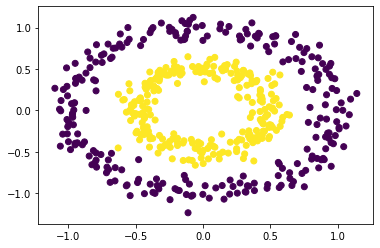

In [ ]:
# Author : Nakul Joseph

# Read dataset to pandas dataframe.
circlesdata = pd.read_csv("circles500.csv")
X = circlesdata.iloc[:, 0:2]
y = circlesdata.iloc[:,-1]

# Plot x0 vs x1 and colour by Y values
plt.scatter(X.iloc[:,0],X.iloc[:,1],c=np.squeeze(y))

# Reshape Y to be a vector 
nrows = y.shape[0]
y = y.to_numpy().reshape(nrows,1)



Our implementation of a one hidden layer neural network is utilized to classify this dataset with high accuracy

We are setting the number of neurons in the hidden layer is 4
The activation of the output layer is the sigmoid function

### Training & Testing

sklearn's preprocessing module allows to split the dataset into 
75 % for training and 25% for testing by default

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 233)

hyper_params = { 'num_iter' : 10000,
                  'activation' : 'sigmoid' ,
                  'hidden_neurons' : 4,
                  'learning_rate' : 0.5}

nn = OneLayerNeuralNet(hyper_params)
nn.fit(X_train,y_train)
y_predicted = nn.predict(X_test)

print("Accuracy :", 100 *accuracy_score(y_test,y_predicted),"%")

====> Cost at epoch  500 0.6931420327688296
====> Cost at epoch  1000 0.6931395002661799
====> Cost at epoch  1500 0.6931333202418706
====> Cost at epoch  2000 0.6931185223901948
====> Cost at epoch  2500 0.6930853877562161
====> Cost at epoch  3000 0.6930214877749247
====> Cost at epoch  3500 0.6929270673207044
====> Cost at epoch  4000 0.6928230696013411
====> Cost at epoch  4500 0.6926969393525636
====> Cost at epoch  5000 0.6923598385974558
====> Cost at epoch  5500 0.6897995314337979
====> Cost at epoch  6000 0.6644117858580165
====> Cost at epoch  6500 0.5910146279330946
====> Cost at epoch  7000 0.5138286544177483
====> Cost at epoch  7500 0.40736690494078615
====> Cost at epoch  8000 0.19883067088677195
====> Cost at epoch  8500 0.137420880519005
====> Cost at epoch  9000 0.1103297560910056
====> Cost at epoch  9500 0.09464933898601749
====> Cost at epoch  10000 0.08402659542278738
Accuracy : 96.8 %


### Observations

The Circles dataset is non-liner therefore Neural network can be used for classification.

A Neural network with 4 neurons in the hidden layer and Sigmoid as the activation function in the hidden and output layer gives us an accuracy of **98.4%** with a learning rate of 0.5 and 10000 iterations.

*   The algorithm fails to converge on the cost if the iterations are less than 10000.
*   We have tested learning rate > 0.5, which gives more accuracy but it tends to overfit the data. Therefore, the learning rate was limited to 0.5. A very low learning rate also shows convergence issues.

Image classification of automobile / truck

Our objective is to classify a given cifar-10 images as an automobile or a truck. 

The cifar-10 dataset is a 10000 X 3072 int values 

Each consecutive 1024 values represents one of Red, Green,Blue  bands

we are using the last 1024 values or the blue band to train and predict the classes.

The lable names are 9 for truck , 1 for automobile
We are encoding trucks class as 0 instead of 9




### Loading CIFAR-10 Images Dataset

In [ ]:
# This function taken from the CIFAR website

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Loaded in this way, each of the batch files contains a dictionary with the following elements:
#   data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. 
#           The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. 
#           The image is stored in row-major order, so that the first 32 entries of the array are the red channel values 
#           of the first row of the image.
#   labels -- a list of 10000 numbers in the range 0-9. 
#             The number at index i indicates the label of the ith image in the array data.

In [ ]:
# This function is taken from Prof Michael Madden's LoadCIFAR10 ipython notebook
d = unpickle('cifar-10-batches-py/batches.meta')
d[b'label_names']

In [ ]:
# This function is taken from Prof Michael Madden's LoadCIFAR10 ipython notebook
def loadbatch(batchname):
    folder = 'cifar-10-batches-py'
    batch = unpickle(folder+"/"+batchname)
    return batch

In [ ]:
# This function is taken from Prof Michael Madden's LoadCIFAR10 ipython notebook
def loadlabelnames():
    folder = 'cifar-10-batches-py'
    meta = unpickle(folder+"/"+'batches.meta')
    return meta[b'label_names']

In [ ]:
# This function is taken from Prof Michael Madden's LoadCIFAR10 ipython notebook
import matplotlib.pyplot as plt

def visualise(data, index):
    # MM Jan 2019: Given a CIFAR data nparray and the index of an image, display the image.
    # Note that the images will be quite fuzzy looking, because they are low res (32x32).

    picture = data[index]
    # Initially, the data is a 1D array of 3072 pixels; reshape it to a 3D array of 3x32x32 pixels
    # Note: after reshaping like this, you could select one colour channel or average them.
    picture.shape = (3,32,32) 
    
    # Plot.imshow requires the RGB to be the third dimension, not the first, so need to rearrange
    picture = picture.transpose([1, 2, 0])
    plt.imshow(picture)
    plt.show()

In [ ]:
# This function is taken from Prof Michael Madden's LoadCIFAR10 ipython notebook
batch1 = loadbatch('data_batch_1')
print("Number of items in the batch is", len(batch1))

# Display all keys, so we can see the ones we want
print('All keys in the batch:', batch1.keys())

In [ ]:
# This function is taken from Prof Michael Madden's LoadCIFAR10 ipython notebook


# all the images in raw RGB values is in data
data = batch1[b'data']
# all the labels match the index of data 
labels = batch1[b'labels']

# Author : Chandrakanth


normalizer = Normalizer()
normalizer.fit(data)
data = normalizer.transform(data)

names = loadlabelnames()


df = pd.DataFrame(data)
# Classes/ labels of all the  images in this batch
df['label'] = pd.Series(labels)

In [ ]:
# class 1 is automobile 
# class 9  is truck

df =df.loc[df['label'].isin([1,9])] # filter the dataframe where image is Auto / truck

l = list(range(2048, 3072)) # Blue band

l.append('label') # list of all the columns we are going to train on 
df = df.loc[:,df.columns.isin(l)] # keep the blue band & the label


In [ ]:
X = df.iloc[:,0:1024] # First 1024 columns are the features
Y = df.iloc[:,-1] # label is the class , last column


Y = Y.replace(9,0)

### Training & Testing

In [ ]:
 #25 % is validation set
X_train,X_test,Y_train,Y_test =  train_test_split(X,Y, random_state=32)

# make the label a vector
Y_train = Y_train.to_numpy().reshape(Y_train.shape[0],1) 
Y_test = Y_test.to_numpy().reshape(Y_test.shape[0],1)

#look at the distribution of the labels
pd.Series(np.squeeze(Y_test)).value_counts()

0    246
1    243
dtype: int64

In [ ]:
hyper_params = { 'num_iter' : 10000,
                  'activation' : 'sigmoid' ,
                  'hidden_neurons' : 20,
                  'learning_rate' : 0.1}

nn = OneLayerNeuralNet(hyper_params)

print("Training started ..")
nn.fit(X_train.iloc[:,0:1024],Y_train)
print("Training completed ..")
y_predicted = nn.predict(X_test)
print("Accuracy :", 100 *accuracy_score(Y_test,y_predicted),"%")

Training started ..
====> Cost at epoch  500 0.6931382083119761
====> Cost at epoch  1000 0.6931319653158128
====> Cost at epoch  1500 0.6931221330232162
====> Cost at epoch  2000 0.6931056267645397
====> Cost at epoch  2500 0.693077269786753
====> Cost at epoch  3000 0.6930281781152265
====> Cost at epoch  3500 0.6929430066349825
====> Cost at epoch  4000 0.692795245601001
====> Cost at epoch  4500 0.6925392544640316
====> Cost at epoch  5000 0.6920970217389443
====> Cost at epoch  5500 0.6913369346620795
====> Cost at epoch  6000 0.6900420192096611
====> Cost at epoch  6500 0.6878689803316594
====> Cost at epoch  7000 0.6843137766240898
====> Cost at epoch  7500 0.678735227749133
====> Cost at epoch  8000 0.6705422787403004
====> Cost at epoch  8500 0.6596414444831789
====> Cost at epoch  9000 0.646966830472638
====> Cost at epoch  9500 0.6344357914638805
====> Cost at epoch  10000 0.6239369357922212
Training completed ..
Accuracy : 67.89366053169734 %


In [ ]:

of_X = X_train.iloc[0:X_test.shape[0],:]
of_Y = Y_train[0:X_test.shape[0],:]
y_train_predicted = nn.predict(of_X)
accuracy_score(of_Y,y_train_predicted)

0.6748466257668712

### Observations

A Neural network with 20 neurons in the hidden layer with Sigmoid as the activation function in both hidden and output layer gave the following results:

*   Accuracy of 67.4% is attained for learning rate of 0.1 and 10000 iterations. 
*  Increasing the neurons greater than 20 is not giving accuracy greater than 67%.

* Cost (Cross entropy loss) decreases from 0.693 to 0.541 at 10000 iterations after that it increases.   





Adding Jitter at input layer 

- Neural networks area known to over fit to training data 
- This enhancement aims at reducing the possibility of over fitting 
- From https://arxiv.org/abs/1406.1831, "Analyzing noise in autoencoders and deep networks" , they showed that adding a gausian noise or jitter helps to curb overfitting for benchmarking datasets like cifar-10 & MNSIT

In [ ]:
''' We will be building on top of the one layer neural network
by creating a class which extends OneLayerNeuralNet 

https://machinelearningmastery.com/train-neural-networks-with-noise-to-reduce-overfitting/

'''
class OneLayerNeuralNet_Jittered (OneLayerNeuralNet) :

  # the standard deviation of used to get random jitters for the input
  __jitter = 0.0

  #Author : Chandrakanth Cheturvedi
  def __init__(self,hyper_params):
    self.__jitter = hyper_params['jitter']
    super().__init__(hyper_params)


  def fit(self,X_train,Y_train):
    print("Training with a jitter of ",self.__jitter,"for all inputs")
    
    '''
        From the URL referenced above
        The most common type of noise used during training is the addition of 
        Gaussian noise to input variables. Gaussian noise, or white noise, 
        has a mean of zero and a standard deviation of one and
         can be generated as needed using a pseudorandom number generator.
    '''

    # get gausian jitter for our training samples
    jittered_train = X_train + np.random.normal(0,self.__jitter,X_train.shape)
    
    super().fit(jittered_train,Y_train)

In [ ]:
# This function is taken from Prof Michael Madden's LoadCIFAR10 ipython notebook
batch1 = loadbatch('data_batch_1')
print("Number of items in the batch is", len(batch1))

# Display all keys, so we can see the ones we want
print('All keys in the batch:', batch1.keys())

# This function is taken from Prof Michael Madden's LoadCIFAR10 ipython notebook


# all the images in raw RGB values is in data
data = batch1[b'data']
# all the labels match the index of data 
labels = batch1[b'labels']

# Author : Chandrakanth
normalizer = Normalizer()
normalizer.fit(data)
data = normalizer.transform(data)

names = loadlabelnames()


df = pd.DataFrame(data)
# Classes/ labels of all the  images in this batch
df['label'] = pd.Series(labels)

# class 1 is automobile 
# class 9  is truck

df =df.loc[df['label'].isin([1,9])] # filter the dataframe where image is Auto / truck

l = list(range(2048, 3072)) # Blue band

l.append('label') # list of all the columns we are going to train on 
df = df.loc[:,df.columns.isin(l)] # keep the blue band & the label

X = df.iloc[:,0:1024] # First 1024 columns are the features
Y = df.iloc[:,-1] # label is the class , last column


Y = Y.replace(9,0)	

 #25 % is validation set
X_train,X_test,Y_train,Y_test =  train_test_split(X,Y, random_state=32)

# make the label a vector
Y_train = Y_train.to_numpy().reshape(Y_train.shape[0],1) 
Y_test = Y_test.to_numpy().reshape(Y_test.shape[0],1)

Number of items in the batch is 4
All keys in the batch: dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [ ]:
hyper_params = { 'num_iter' : 10000,
                  'activation' : 'ReLU' ,
                  'hidden_neurons' : 20,
                  'learning_rate' : 0.1 ,
                  'jitter' : 0.001 }

nn = OneLayerNeuralNet_Jittered(hyper_params)
nn.fit(X_train,Y_train)

Training with a jitter of  0.001 for all inputs
====> Cost at epoch  500 0.6930365630816524
====> Cost at epoch  1000 0.6922149066998778
====> Cost at epoch  1500 0.6856713595977477
====> Cost at epoch  2000 0.652754328726554
====> Cost at epoch  2500 0.6134006666457877
====> Cost at epoch  3000 0.6024481102638497
====> Cost at epoch  3500 0.5970871081025062
====> Cost at epoch  4000 0.5921784360620092
====> Cost at epoch  4500 0.5873211540599859
====> Cost at epoch  5000 0.5824377331949409
====> Cost at epoch  5500 0.5774474219249747
====> Cost at epoch  6000 0.5724350326714405
====> Cost at epoch  6500 0.5673755110618991
====> Cost at epoch  7000 0.5623355367667251
====> Cost at epoch  7500 0.5573450274177046
====> Cost at epoch  8000 0.5524514925900863
====> Cost at epoch  8500 0.5476340888295602
====> Cost at epoch  9000 0.5428735458868805
====> Cost at epoch  9500 0.5381622975342004
====> Cost at epoch  10000 0.5334763128797062


In [ ]:
y_predicted = nn.predict(X_test)
accuracy_score(Y_test,y_predicted)

0.6830265848670757

### Observation on the enhancement.

*   Accuracy improved from **67.8** to **68.3**
*   Increasing the no of neurons in the hidden layer doesn't improve the accuracy
*   Changing the learning rate to 0.5 not decreasing the as it would do with 0.1
*   Jittering by 1 % of the actual X values gives us improvements 
*   anything higher than 0.01 jitter reduces the accuracy for normalised cifar-10 dataset


## References

https://towardsdatascience.com/complete-guide-of-activation-functions-34076e95d044

https://www.coursera.org/learn/neural-networks-deep-learning/home/info

https://towardsdatascience.com/how-to-debug-a-neural-network-with-gradient-checking-41deec0357a9

https://towardsdatascience.com/checklist-for-debugging-neural-networks-d8b2a9434f21

lecture slides